In [1]:
##################################################################################################
# Patch-based Classification of Breast Cancer Histology Images using CNNs
# LE48: MiniProject
# Jan Ondras (jo356), Trinity College
# 2017/2018
##################################################################################################

####################################################################################################
# TESTING THE BEST RCNN MODEL, all 4 voting schemes, 3 types of test set (most recent)
# only for original test set
####################################################################################################

####################################################################################################
# Load model for testing
####################################################################################################

from keras.models import load_model

test_model_name = './../Model/RCNN_256_256_00/RCNN_256_256_00_005.hdf5'


model = load_model(test_model_name)
print model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 48, 254, 254, 16)  448       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 48, 84, 84, 16)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 48, 82, 82, 32)    4640      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 48, 41, 41, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 48, 41, 41, 64)    18496     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 48, 20, 20, 64)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 48, 20, 20, 64)    36928     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        36928     
__________

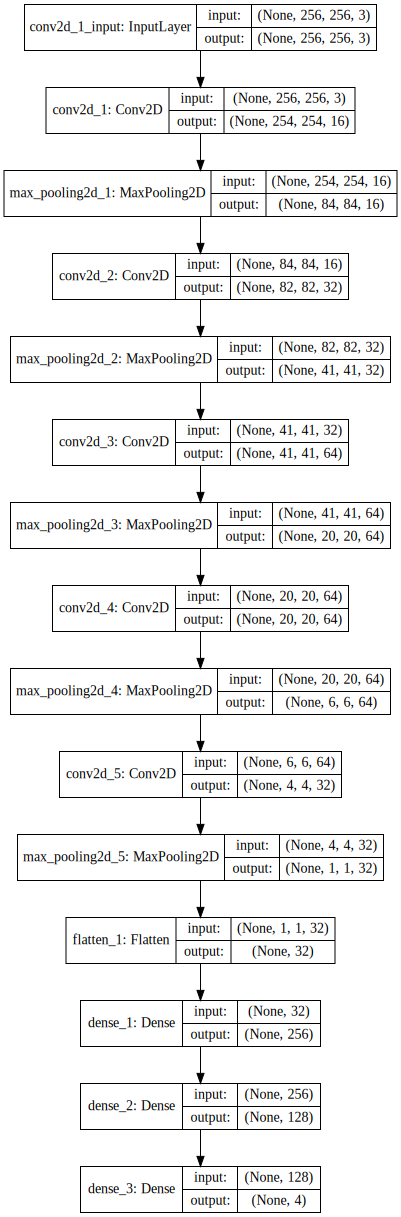

In [2]:
##################################################################################################
# Show model & save as figure
##################################################################################################
# Show model: https://keras.io/visualization/

#################################################
# Tofile
from keras.utils import plot_model
plot_model(model, to_file='model_ ' + test_model_name.split('/')[-1][:-5] + '.png', 
           show_shapes=True, show_layer_names=True)

#################################################
# Inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [13]:
####################################################################################################
# Predict on Test set
####################################################################################################

from sklearn.metrics import recall_score, accuracy_score
import sys
# import tifffile as tiff
import os
import numpy as np
# from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import glob
from keras.preprocessing import image
from keras.utils import to_categorical

####################################################################################################

RGB_means = [
    180.375933345 , 148.276127037 , 174.592562423
] 
# AWS: 180.375933345 , 148.276127037 , 174.592562423
# HPC: 180.7795009644826 , 148.3537065177495 , 174.59451631969864

# Image size (assume same for all images)
img_width =  2048
img_height = 1536
pix_scale = 0.42 # micrometers

target_size = (256, 256)
    
# Create patches
patch_width = 256
patch_height = patch_width
patch_stride = patch_width
N_patches_x = (((img_width - patch_width) / patch_stride) + 1)
N_patches_y = (((img_height - patch_height) / patch_stride) + 1)
N_patches_per_img = N_patches_x * N_patches_y
print "Number of patches per image: ", N_patches_per_img, " = ", N_patches_x, " x ", N_patches_y

true_labels = np.concatenate( (np.repeat(0, 5), np.repeat(1, 5), np.repeat(2, 5), np.repeat(3, 5), 
                               np.repeat(0, 4), np.repeat(1, 4), np.repeat(2, 4), np.repeat(3, 4)))
N_test_imgs = len(true_labels)

print "#test images =", N_test_imgs
print "True labels = ", true_labels

path_prefix = './../Dataset/ICIAR2018_BACH_Challenge/Test_org_SN/'

classes = ['Normal', 'Benign', 'InSitu', 'Invasive'] # the same order as labels 0,1,2,3

PREDICTIONS = np.zeros( (N_test_imgs) ) # only image-wise !!!

def substract_mean(patch):
    # RGB
    patch[:,:,0] -= RGB_means[0]
    patch[:,:,1] -= RGB_means[1]
    patch[:,:,2] -= RGB_means[2]
    return patch

def p_argmax(a): # Priority based arg max function, to handle draws in correct order
    m = np.max(a)
    
    if a[3] == m: # Invasive
        return 3
    if a[2] == m: # InSitu
        return 2
    if a[1] == m: # Benign
        return 1
    if a[0] == m: # Normal
        return 0

def img_to_patches(imgs): # also resize
    '''
    Input = (1536, 2048, 3)
    Output = (N_patches_per_img, 256, 256, 3)
    '''
    patches = np.zeros( (N_patches_per_img, target_size[0], target_size[1], 3) )

    # Iterate over patches
    patchID = 0
    for i in range(N_patches_x):
        for j in range(N_patches_y):
            p = imgs[j*patch_stride:j*patch_stride + patch_height, i*patch_stride:i*patch_stride + patch_width, :]
            #print p.shape
            # Resize to target_size TODOOOOOOOOO
            #Image.fromarray(p).resize(target_size).getdata()
            p = cv2.resize(p, target_size, interpolation=cv2.INTER_NEAREST)
            patches[patchID] = p
            #patches.append( img[j*patch_stride:j*patch_stride + patch_height, i*patch_stride:i*patch_stride + patch_width, :] )

            patchID += 1
    if patchID != N_patches_per_img:
        raise ValueError("Incorrect number of patches per image!")

    return patches

# Iterate over test images
for img_name in glob.glob(path_prefix + '*.tif'): # can be any order, predictions are saved using indexing
#     print img_name
    img = image.img_to_array(image.load_img(img_name)) # RGB channel order
    imgID = int((img_name.split('/')[-1]).split('.')[-2])
#     print imgID
    true_img_label = true_labels[imgID] # true label for this image is: true_labels[imgID]
    
    img = substract_mean(img)
    ps = img_to_patches(img)
    
    rs_ps = np.reshape(ps, [1, N_patches_per_img, target_size[0],target_size[1], 3]) # reshape
    
    PREDICTIONS[imgID] = p_argmax( model.predict_proba(rs_ps)[0] )     #model.predict_classes(rs_ps, verbose=1)[0] # model.predict_proba(rs_ps)[0]
    #print p_argmax( model.predict_proba(rs_ps)[0] ) # to reslove drawbacks appropriately
    #print imgID, PREDICTIONS[imgID]       

 Number of patches per image:  48  =  8  x  6
#test images = 36
True labels =  [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


In [15]:
# From gathered predicitons calculated metrics for various datasets

# print PREDICTIONS

# For every type of dataset
dataset_types = ['Initial', 'Extended', 'Overall']

for dt in dataset_types:
    print "\n=========================================================================================="
    print "Dataset type: ", dt
    print "==========================================================================================\n"
    
    if dt == 'Initial': # first 20
        P = PREDICTIONS[:20]
        TL = true_labels[:20]
    if dt == 'Extended': # last 16
        P = PREDICTIONS[20:]
        TL = true_labels[20:]
    if dt == 'Overall': # all 36
        P = PREDICTIONS
        TL = true_labels
#     print len(P) == len(TL), len(P)
#     print P, TL

    # FOR IMAGE-WISE: calculate accuracy/sesitivity 
    print "\nImage-wise:\n------------------------------------------------------------------------------\n"
    
    print "\tAccuracy = ", accuracy_score(TL, P)
    print "\tSensitivity (recall) = ", recall_score(TL, P, average=None)
    


Dataset type:  Initial


Image-wise:
------------------------------------------------------------------------------

	Accuracy =  0.25
	Sensitivity (recall) =  [ 0.  0.  1.  0.]

Dataset type:  Extended


Image-wise:
------------------------------------------------------------------------------

	Accuracy =  0.25
	Sensitivity (recall) =  [ 0.  0.  1.  0.]

Dataset type:  Overall


Image-wise:
------------------------------------------------------------------------------

	Accuracy =  0.25
	Sensitivity (recall) =  [ 0.  0.  1.  0.]
